Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


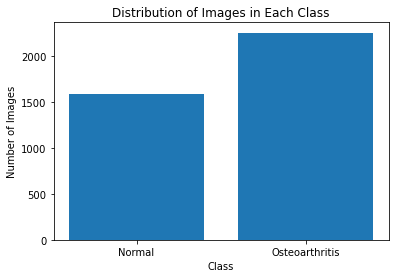

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML4/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML4/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-22 17:46:57.070500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 17:46:57.070673: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 17:46:57.072266: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 17:46:57.089793: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 17:46:57.426306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


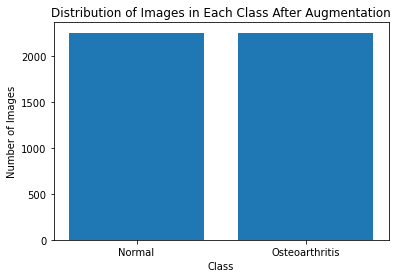

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML4/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML4/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 500)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 500)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 500 + [1] * 500  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 560
X_test size: 300
X_validation size: 140


# MobileNet+Dense

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

import numpy as np

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,491,778 (13.32 MB)

 Trainable params: 262,914 (1.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [28]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.5241 - loss: 1.3718 - val_accuracy: 0.7429 - val_loss: 0.5266
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.8117 - loss: 0.4105 - val_accuracy: 0.8071 - val_loss: 0.4194
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.8548 - loss: 0.3458 - val_accuracy: 0.8214 - val_loss: 0.3909
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.8970 - loss: 0.2697 - val_accuracy: 0.8357 - val_loss: 0.3758
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.9139 - loss: 0.2388 - val_accuracy: 0.8357 - val_loss: 0.3776
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.9426 - loss: 0.1921 - val_accuracy: 0.7571 - val_loss: 0.4428
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.9119 - loss: 0.2004 - val_accuracy: 0.8357 - val_loss: 0.3523
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.9412 - loss: 0.1715 - val_accuracy: 0.

Validation Loss: 0.3401418626308441
Validation Accuracy: 0.8500000238418579
Test Loss: 0.3729791045188904
Test Accuracy: 0.8399999737739563
Inference Time (Test set): 2.129143714904785 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       150
           1       0.90      0.77      0.83       150

    accuracy                           0.84       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.84      0.84       300

Confusion Matrix:
[[137  13]
 [ 35 115]]


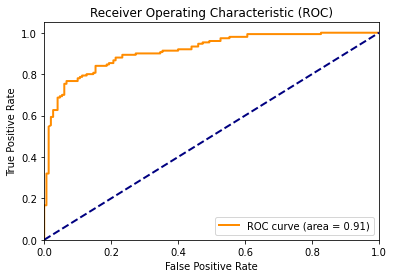

Metrics saved successfully


In [29]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef
import pandas as pd
# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [30]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9525 - loss: 0.1491 - val_accuracy: 0.8429 - val_loss: 0.3802
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.9606 - loss: 0.1284 - val_accuracy: 0.8500 - val_loss: 0.3587
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.9875 - loss: 0.1054 - val_accuracy: 0.8500 - val_loss: 0.3599
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.9909 - loss: 0.0868 - val_accuracy: 0.8500 - val_loss: 0.3717
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.9772 - loss: 0.0834 - val_accuracy: 0.8429 - val_loss: 0.3614
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.9944 - loss: 0.0767 - val_accuracy: 0.8357 - val_loss: 0.4138
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9803 - loss: 0.0743 - val_accuracy: 0.8143 - val_loss: 0.4517
Training Time: 23.586523056030273 seconds


Validation Loss: 0.358661949634552
Validation Accuracy: 0.8500000238418579
Test Loss: 0.37471991777420044
Test Accuracy: 0.8533333539962769
Inference Time (Test set): 2.1423120498657227 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       150
           1       0.92      0.77      0.84       150

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300

Confusion Matrix:
[[140  10]
 [ 34 116]]


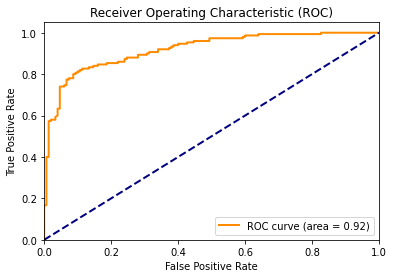

Metrics saved successfully


In [31]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")



In [32]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9717 - loss: 0.1097 - val_accuracy: 0.8357 - val_loss: 0.3703
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9638 - loss: 0.1106 - val_accuracy: 0.8643 - val_loss: 0.3563
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9594 - loss: 0.1031 - val_accuracy: 0.8286 - val_loss: 0.4200
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9574 - loss: 0.1090 - val_accuracy: 0.8286 - val_loss: 0.3794
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9708 - loss: 0.0871 - val_accuracy: 0.8357 - val_loss: 0.3883
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9934 - loss: 0.0520 - val_accuracy: 0.8286 - val_loss: 0.4142
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9997 - loss: 0.0383 - val_accuracy: 0.8571 - val_loss: 0.3863
Training Time: 24.020097970962524 seconds


Validation Loss: 0.3562793731689453
Validation Accuracy: 0.8642857074737549
Test Loss: 0.36024704575538635
Test Accuracy: 0.8566666841506958
Inference Time (Test set): 2.17805814743042 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       150
           1       0.93      0.77      0.84       150

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300

Confusion Matrix:
[[142   8]
 [ 35 115]]


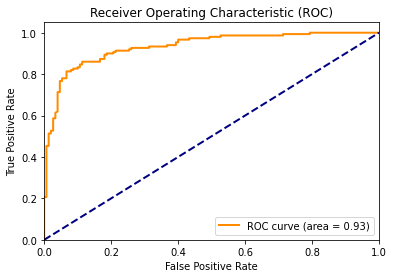

Metrics saved successfully


In [33]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'MObilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")



In [34]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9859 - loss: 0.0883 - val_accuracy: 0.8500 - val_loss: 0.3786
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9757 - loss: 0.0807 - val_accuracy: 0.8429 - val_loss: 0.3836
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9935 - loss: 0.0617 - val_accuracy: 0.8500 - val_loss: 0.4210
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9870 - loss: 0.0583 - val_accuracy: 0.8143 - val_loss: 0.4480
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9972 - loss: 0.0466 - val_accuracy: 0.8714 - val_loss: 0.3859
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 1.0000 - loss: 0.0364 - val_accuracy: 0.8500 - val_loss: 0.3913
Training Time: 20.507007360458374 seconds


Validation Loss: 0.3785780072212219
Validation Accuracy: 0.8500000238418579
Test Loss: 0.3948083817958832
Test Accuracy: 0.846666693687439
Inference Time (Test set): 2.17944073677063 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       150
           1       0.93      0.75      0.83       150

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300

Confusion Matrix:
[[142   8]
 [ 38 112]]


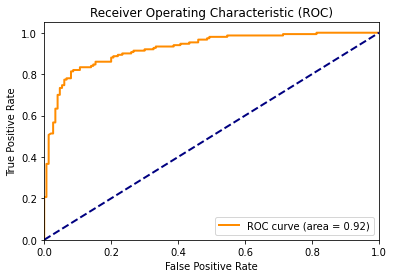

Metrics saved successfully


In [35]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# MobileNet+Dense+Dropout

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add dropout regularization
x = Dropout(0.5)(x)  # Adjust dropout rate as needed

# Define the number of output classes based on your data
num_classes = len(np.unique(y_train))

# Add a final classification layer with softmax activation
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,491,778 (13.32 MB)

 Trainable params: 262,914 (1.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [37]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.4806 - loss: 0.8247 - val_accuracy: 0.4500 - val_loss: 0.7330
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.4772 - loss: 0.7484 - val_accuracy: 0.4500 - val_loss: 0.7034
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.5404 - loss: 0.6997 - val_accuracy: 0.5500 - val_loss: 0.6872
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.5367 - loss: 0.7038 - val_accuracy: 0.5500 - val_loss: 0.6876
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5100 - loss: 0.6990 - val_accuracy: 0.5500 - val_loss: 0.6874
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.4934 - loss: 0.7062 - val_accuracy: 0.4500 - val_loss: 0.6992
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.4871 - loss: 0.7035 - val_accuracy: 0.4500 - val_loss: 0.7027
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4890 - loss: 0.7042 - val_accuracy: 0.

Validation Loss: 0.687195897102356
Validation Accuracy: 0.550000011920929
Test Loss: 0.6963103413581848
Test Accuracy: 0.5
Inference Time (Test set): 2.249319553375244 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


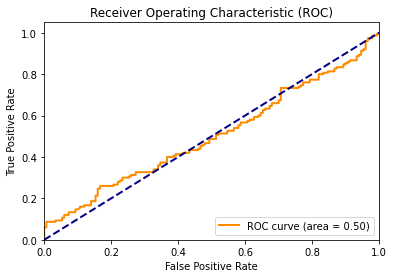

Metrics saved successfully


In [38]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [39]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.5097 - loss: 0.7161 - val_accuracy: 0.5500 - val_loss: 0.6943
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.4978 - loss: 0.7071 - val_accuracy: 0.4500 - val_loss: 0.7063
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.5090 - loss: 0.7041 - val_accuracy: 0.4500 - val_loss: 0.7158
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.4860 - loss: 0.7025 - val_accuracy: 0.4500 - val_loss: 0.7051
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.5250 - loss: 0.6969 - val_accuracy: 0.4500 - val_loss: 0.6980
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.5166 - loss: 0.7012 - val_accuracy: 0.5643 - val_loss: 0.6918
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5069 - loss: 0.6989 - val_accuracy: 0.4500 - val_loss: 0.7047
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5252 - loss: 0.6952 - val_accu

Validation Loss: 0.6915713548660278
Validation Accuracy: 0.5285714268684387
Test Loss: 0.692537784576416
Test Accuracy: 0.5133333206176758
Inference Time (Test set): 2.175900936126709 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.85      0.64       150
           1       0.54      0.17      0.26       150

    accuracy                           0.51       300
   macro avg       0.52      0.51      0.45       300
weighted avg       0.52      0.51      0.45       300

Confusion Matrix:
[[128  22]
 [124  26]]


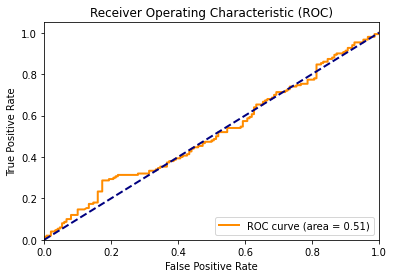

Metrics saved successfully


In [40]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")



In [41]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.5225 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6972
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4658 - loss: 0.6949 - val_accuracy: 0.4500 - val_loss: 0.6978
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4849 - loss: 0.6948 - val_accuracy: 0.4500 - val_loss: 0.6955
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.5208 - loss: 0.6914 - val_accuracy: 0.4786 - val_loss: 0.6935
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.4950 - loss: 0.6948 - val_accuracy: 0.4500 - val_loss: 0.7001
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.4813 - loss: 0.6960 - val_accuracy: 0.4357 - val_loss: 0.6940
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4872 - loss: 0.6967 - val_accuracy: 0.4500 - val_loss: 0.7017
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.4970 - loss: 0.6974 - val_accu

Validation Loss: 0.6923938989639282
Validation Accuracy: 0.5571428537368774
Test Loss: 0.693088948726654
Test Accuracy: 0.5333333611488342
Inference Time (Test set): 2.207871437072754 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.78      0.63       150
           1       0.57      0.29      0.38       150

    accuracy                           0.53       300
   macro avg       0.54      0.53      0.50       300
weighted avg       0.54      0.53      0.50       300

Confusion Matrix:
[[117  33]
 [107  43]]


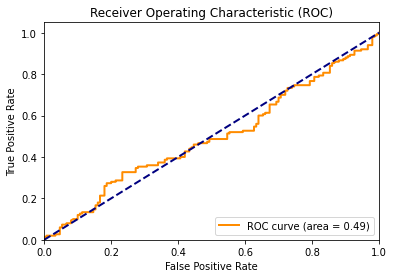

Metrics saved successfully


In [42]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")


In [43]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.5138 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6959
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.5065 - loss: 0.6913 - val_accuracy: 0.4500 - val_loss: 0.6962
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.4873 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6956
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5207 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6975
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5026 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6976
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.5220 - loss: 0.6903 - val_accuracy: 0.4500 - val_loss: 0.6985
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5055 - loss: 0.6940 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5367 - loss: 0.6922 - val_accu

Validation Loss: 0.6923993229866028
Validation Accuracy: 0.5714285969734192
Test Loss: 0.6930285096168518
Test Accuracy: 0.5266666412353516
Inference Time (Test set): 2.1760685443878174 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62       150
           1       0.55      0.29      0.38       150

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.50       300
weighted avg       0.53      0.53      0.50       300

Confusion Matrix:
[[115  35]
 [107  43]]


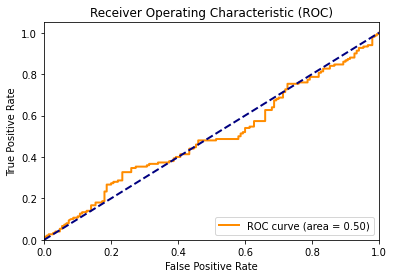

Metrics saved successfully


In [44]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a Conv2D layer
x = Conv2D(64, (3, 3), activation='relu', padding='same')(base_model.output)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a dropout layer
x = Dropout(0.5)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,835,906 (14.63 MB)

 Trainable params: 607,042 (2.32 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.4961 - loss: 0.7588 - val_accuracy: 0.4500 - val_loss: 0.7289
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.5252 - loss: 0.7155 - val_accuracy: 0.5500 - val_loss: 0.6897
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.5260 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6987
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.4760 - loss: 0.6979 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.4750 - loss: 0.6949 - val_accuracy: 0.4500 - val_loss: 0.7004
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.5222 - loss: 0.6907 - val_accuracy: 0.5500 - val_loss: 0.6925
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.4750 - loss: 0.6938 - val_accuracy: 0.4500 - val_loss: 0.6935
Training Time: 25.19404363632202 seconds


Validation Loss: 0.6897400617599487
Validation Accuracy: 0.550000011920929
Test Loss: 0.6935297846794128
Test Accuracy: 0.5
Inference Time (Test set): 2.2284631729125977 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


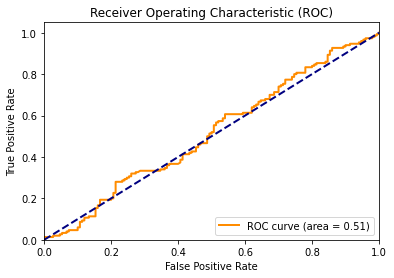

Metrics saved successfully


In [7]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef
import pandas as pd

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.4448 - loss: 0.6985 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.5193 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.6994
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.5525 - loss: 0.6889 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5289 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6971
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.5276 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6980
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.5078 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6958
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4485 - loss: 0.6946 - val_accuracy: 0.4500 - val_loss: 0.6946
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4700 - loss: 0.6934 - val_accu

Validation Loss: 0.6941059827804565
Validation Accuracy: 0.44999998807907104
Test Loss: 0.6932762861251831
Test Accuracy: 0.5
Inference Time (Test set): 2.1413960456848145 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.50      1.00      0.67       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[  0 150]
 [  0 150]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


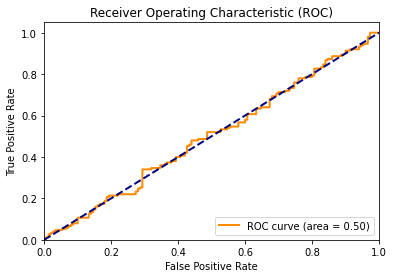

Metrics saved successfully


In [9]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.4935 - loss: 0.6938 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.5325 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6973
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.5136 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6954
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.4870 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.5353 - loss: 0.6922 - val_accuracy: 0.4500 - val_loss: 0.6969
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.4762 - loss: 0.6955 - val_accuracy: 0.4500 - val_loss: 0.6948
Training Time: 21.0298593044281 seconds


Validation Loss: 0.6938208937644958
Validation Accuracy: 0.44999998807907104
Test Loss: 0.6932064294815063
Test Accuracy: 0.5
Inference Time (Test set): 2.1966052055358887 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.50      1.00      0.67       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[  0 150]
 [  0 150]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


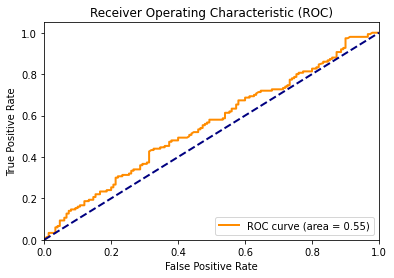

Metrics saved successfully


In [11]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.4924 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6951
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.5455 - loss: 0.6923 - val_accuracy: 0.4500 - val_loss: 0.7013
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.5140 - loss: 0.6953 - val_accuracy: 0.4500 - val_loss: 0.6967
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.5019 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6969
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.5187 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6973
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.5195 - loss: 0.6921 - val_accuracy: 0.4500 - val_loss: 0.6980
Training Time: 21.318323612213135 seconds


Validation Loss: 0.6950916051864624
Validation Accuracy: 0.44999998807907104
Test Loss: 0.6934517025947571
Test Accuracy: 0.5
Inference Time (Test set): 2.19655442237854 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.50      1.00      0.67       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[  0 150]
 [  0 150]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


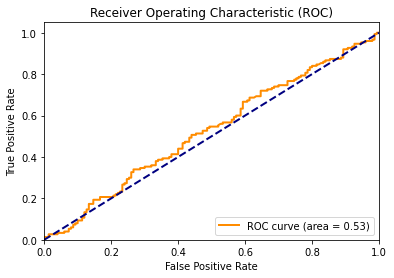

Metrics saved successfully


In [13]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+LSTM+Dense

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Reshape
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)  # Assuming input images are 224x224 RGB images

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Flatten layer to convert 4D tensor to 2D tensor
x = Flatten()(base_model.output)

# Reshape to 3D tensor for LSTM input (assuming LSTM expects time_steps as first dimension)
x = Reshape((-1, 1024))(x)

# Add LSTM layer
x = LSTM(128)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
num_classes = 2  # Assuming you have 2 classes

# Add the final classification layer with softmax activation
predictions = Dense(num_classes, activation='softmax')(x)  # Adjusted for 2 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,852,738 (14.70 MB)

 Trainable params: 623,874 (2.38 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [29]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.5144 - loss: 0.7123 - val_accuracy: 0.5500 - val_loss: 0.6912
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.4831 - loss: 0.6989 - val_accuracy: 0.5500 - val_loss: 0.6873
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.5271 - loss: 0.6950 - val_accuracy: 0.4500 - val_loss: 0.7028
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.4983 - loss: 0.6942 - val_accuracy: 0.4500 - val_loss: 0.6970
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.4655 - loss: 0.6960 - val_accuracy: 0.4500 - val_loss: 0.7146
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.4883 - loss: 0.7016 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.4954 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6970
Training Time: 26.3487331867218 seconds


Validation Loss: 0.6873298287391663
Validation Accuracy: 0.550000011920929
Test Loss: 0.6968808770179749
Test Accuracy: 0.5
Inference Time (Test set): 2.2895140647888184 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


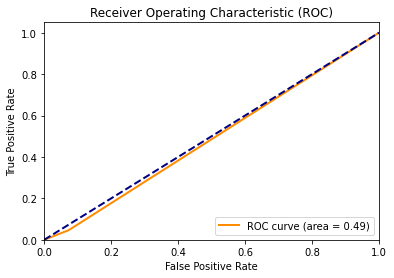

Metrics saved successfully


In [30]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [31]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.5230 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.7283
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5097 - loss: 0.6989 - val_accuracy: 0.5500 - val_loss: 0.6903
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5142 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.7075
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.4677 - loss: 0.7006 - val_accuracy: 0.4500 - val_loss: 0.7102
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.5322 - loss: 0.6907 - val_accuracy: 0.5500 - val_loss: 0.6900
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.5008 - loss: 0.6965 - val_accuracy: 0.4500 - val_loss: 0.7021
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.4898 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6961
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.5092 - loss: 0.6934 - val_accu

Validation Loss: 0.6900089383125305
Validation Accuracy: 0.550000011920929
Test Loss: 0.6933813691139221
Test Accuracy: 0.5
Inference Time (Test set): 2.315873146057129 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


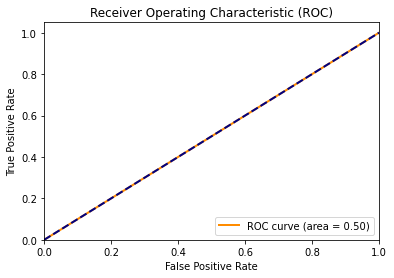

Metrics saved successfully


In [32]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [33]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.4945 - loss: 0.6942 - val_accuracy: 0.4500 - val_loss: 0.7027
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.5200 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6968
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.5074 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.5367 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6922
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5111 - loss: 0.6943 - val_accuracy: 0.4500 - val_loss: 0.7034
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.4981 - loss: 0.6971 - val_accuracy: 0.4500 - val_loss: 0.6986
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.5322 - loss: 0.6937 - val_accuracy: 0.5500 - val_loss: 0.6906
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.4728 - loss: 0.6981 - val_accu

Validation Loss: 0.6905909776687622
Validation Accuracy: 0.550000011920929
Test Loss: 0.6932294964790344
Test Accuracy: 0.5
Inference Time (Test set): 2.2855775356292725 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


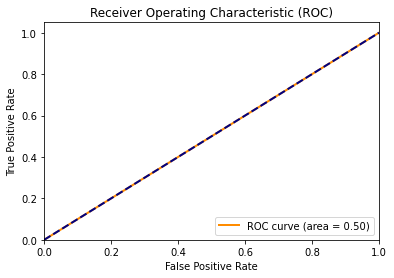

Metrics saved successfully


In [34]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [35]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.4977 - loss: 0.6943 - val_accuracy: 0.4500 - val_loss: 0.6991
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5040 - loss: 0.6976 - val_accuracy: 0.4500 - val_loss: 0.6969
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.4914 - loss: 0.6939 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5003 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6962
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5066 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6969
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.4904 - loss: 0.6946 - val_accuracy: 0.4500 - val_loss: 0.6976
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.5395 - loss: 0.6920 - val_accuracy: 0.4500 - val_loss: 0.6962
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.4533 - loss: 0.6950 - val_accu

Validation Loss: 0.6950165033340454
Validation Accuracy: 0.44999998807907104
Test Loss: 0.6934435963630676
Test Accuracy: 0.5
Inference Time (Test set): 2.280158281326294 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.50      1.00      0.67       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[  0 150]
 [  0 150]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


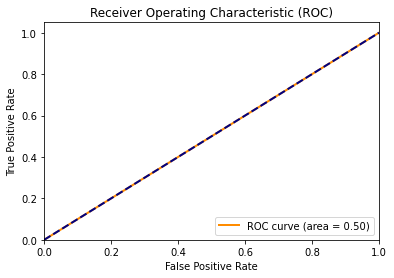

Metrics saved successfully


In [36]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+GRU+Dense

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224,224,3)  # You need to define the time steps and features

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.layers import Flatten, Reshape

# Add Flatten layer to convert 4D tensor to 2D tensor
x = Flatten()(base_model.output)

# Reshape to 3D tensor for GRU input (assuming GRU expects time_steps as first dimension)
x = Reshape((-1, 7*7*1024))(x)

# Add GRU layer
x = GRU(128)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming num_classes is the number of output classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 22,579,906 (86.14 MB)

 Trainable params: 19,351,042 (73.82 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [40]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.4523 - loss: 0.9968 - val_accuracy: 0.5500 - val_loss: 0.6892
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.5126 - loss: 0.6957 - val_accuracy: 0.4500 - val_loss: 0.6993
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.5252 - loss: 0.6925 - val_accuracy: 0.5500 - val_loss: 0.6891
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.4860 - loss: 0.7001 - val_accuracy: 0.5500 - val_loss: 0.6879
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.4766 - loss: 0.6993 - val_accuracy: 0.4500 - val_loss: 0.6954
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.4899 - loss: 0.6966 - val_accuracy: 0.4500 - val_loss: 0.7454
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.4870 - loss: 0.7180 - val_accuracy: 0.4500 - val_loss: 0.7600
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.5037 - loss: 0.7234 - val_accuracy: 0.

Validation Loss: 0.6878599524497986
Validation Accuracy: 0.550000011920929
Test Loss: 0.695123016834259
Test Accuracy: 0.5
Inference Time (Test set): 2.2020740509033203 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


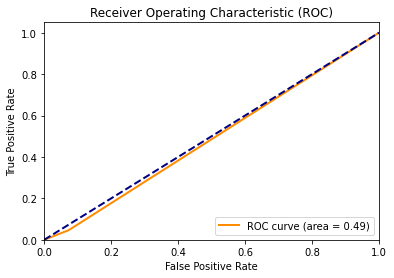

Metrics saved successfully


In [41]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [42]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.5348 - loss: 0.6987 - val_accuracy: 0.4500 - val_loss: 0.7153
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.4872 - loss: 0.6990 - val_accuracy: 0.4500 - val_loss: 0.7119
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.5244 - loss: 0.6951 - val_accuracy: 0.5500 - val_loss: 0.6874
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.5622 - loss: 0.6865 - val_accuracy: 0.4500 - val_loss: 0.7393
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.4814 - loss: 0.7121 - val_accuracy: 0.4500 - val_loss: 0.7168
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.4824 - loss: 0.7011 - val_accuracy: 0.4500 - val_loss: 0.7039
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.4933 - loss: 0.7021 - val_accuracy: 0.4500 - val_loss: 0.7666
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.4603 - loss: 0.7326 - val_accu

Validation Loss: 0.6874047517776489
Validation Accuracy: 0.550000011920929
Test Loss: 0.6996867656707764
Test Accuracy: 0.5
Inference Time (Test set): 2.334829330444336 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


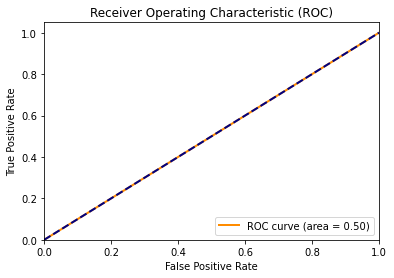

Metrics saved successfully


In [43]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [44]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.4920 - loss: 0.7015 - val_accuracy: 0.5500 - val_loss: 0.6904
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.4930 - loss: 0.6977 - val_accuracy: 0.5500 - val_loss: 0.6899
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.4942 - loss: 0.6958 - val_accuracy: 0.4500 - val_loss: 0.6975
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.5173 - loss: 0.6980 - val_accuracy: 0.4500 - val_loss: 0.7548
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.5113 - loss: 0.7083 - val_accuracy: 0.5500 - val_loss: 0.6878
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - accuracy: 0.4803 - loss: 0.6979 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.4787 - loss: 0.6949 - val_accuracy: 0.4500 - val_loss: 0.7056
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.4584 - loss: 0.7026 - val_accu

Validation Loss: 0.6877833604812622
Validation Accuracy: 0.550000011920929
Test Loss: 0.6952725648880005
Test Accuracy: 0.5
Inference Time (Test set): 2.237079381942749 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


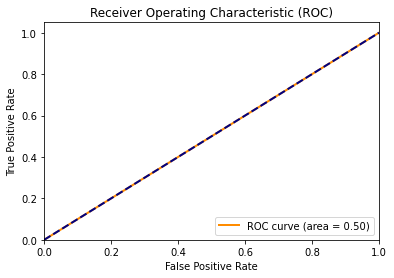

Metrics saved successfully


In [45]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [46]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - accuracy: 0.5063 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.7077
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.4853 - loss: 0.6968 - val_accuracy: 0.4500 - val_loss: 0.7053
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - accuracy: 0.4810 - loss: 0.6979 - val_accuracy: 0.5500 - val_loss: 0.6893
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.4936 - loss: 0.6955 - val_accuracy: 0.4500 - val_loss: 0.7013
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.4612 - loss: 0.6980 - val_accuracy: 0.4500 - val_loss: 0.7136
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.4803 - loss: 0.7021 - val_accuracy: 0.4500 - val_loss: 0.7098
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.5047 - loss: 0.6961 - val_accuracy: 0.5500 - val_loss: 0.6927
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.5102 - loss: 0.6949 - val_accu

Validation Loss: 0.6877468824386597
Validation Accuracy: 0.550000011920929
Test Loss: 0.7014495134353638
Test Accuracy: 0.5
Inference Time (Test set): 2.2464499473571777 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


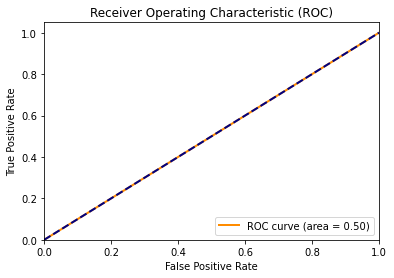

Metrics saved successfully


In [47]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Attention Mechanism+Dense

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Reshape, Permute, Multiply
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add attention mechanism
attention_probs = Dense(1, activation='softmax')(base_model.output)
attention_mul = Multiply()([base_model.output, attention_probs])

# Add a global average pooling layer
x = GlobalAveragePooling2D()(attention_mul)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 112, 112,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 112, 112,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 112, 112,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 112, 112,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 112, 112,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 112, 112,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 113, 113,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 56, 56,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 56, 56,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 56, 56,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 56, 56,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 56, 56,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 56, 56,    │          0 │ conv_pw_2_bn[0][

 Total params: 3,492,803 (13.32 MB)

 Trainable params: 263,939 (1.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [50]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.5004 - loss: 0.7234 - val_accuracy: 0.4500 - val_loss: 0.7022
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.5031 - loss: 0.6996 - val_accuracy: 0.4500 - val_loss: 0.7331
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.5060 - loss: 0.7147 - val_accuracy: 0.4500 - val_loss: 0.7919
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.4582 - loss: 0.7405 - val_accuracy: 0.4500 - val_loss: 0.7097
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.5196 - loss: 0.7039 - val_accuracy: 0.4500 - val_loss: 0.7108
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.4800 - loss: 0.6984 - val_accuracy: 0.5500 - val_loss: 0.6899
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.5466 - loss: 0.7023 - val_accuracy: 0.4500 - val_loss: 0.7048
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.4987 - loss: 0.6937 - val_accuracy: 0.

Validation Loss: 0.6899474859237671
Validation Accuracy: 0.550000011920929
Test Loss: 0.6934019327163696
Test Accuracy: 0.5
Inference Time (Test set): 2.1298413276672363 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


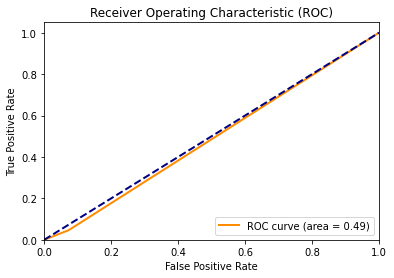

Metrics saved successfully


In [51]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [52]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.5101 - loss: 0.6971 - val_accuracy: 0.5500 - val_loss: 0.6876
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.5144 - loss: 0.7056 - val_accuracy: 0.5500 - val_loss: 0.6892
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5205 - loss: 0.7174 - val_accuracy: 0.4500 - val_loss: 0.7031
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5498 - loss: 0.6925 - val_accuracy: 0.5500 - val_loss: 0.6873
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.4679 - loss: 0.7013 - val_accuracy: 0.4500 - val_loss: 0.7162
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5232 - loss: 0.6895 - val_accuracy: 0.5500 - val_loss: 0.6882
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4818 - loss: 0.7074 - val_accuracy: 0.5500 - val_loss: 0.6881
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.4604 - loss: 0.7046 - val_accu

Validation Loss: 0.6873144507408142
Validation Accuracy: 0.550000011920929
Test Loss: 0.69701087474823
Test Accuracy: 0.5
Inference Time (Test set): 2.1829605102539062 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


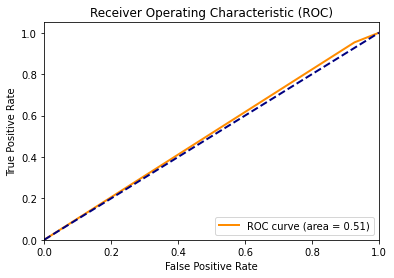

Metrics saved successfully


In [53]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [54]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.5244 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.7041
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.5366 - loss: 0.6981 - val_accuracy: 0.5500 - val_loss: 0.6876
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5259 - loss: 0.6930 - val_accuracy: 0.5500 - val_loss: 0.6892
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5334 - loss: 0.7001 - val_accuracy: 0.4500 - val_loss: 0.7419
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.4964 - loss: 0.7060 - val_accuracy: 0.4500 - val_loss: 0.7124
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.5103 - loss: 0.6963 - val_accuracy: 0.4500 - val_loss: 0.7154
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.5289 - loss: 0.6954 - val_accuracy: 0.5500 - val_loss: 0.6876
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4942 - loss: 0.7035 - val_accu

Validation Loss: 0.6875790357589722
Validation Accuracy: 0.550000011920929
Test Loss: 0.6957723498344421
Test Accuracy: 0.5
Inference Time (Test set): 2.2443490028381348 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


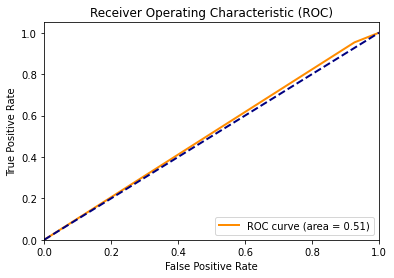

Metrics saved successfully


In [55]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [56]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.4898 - loss: 0.7012 - val_accuracy: 0.5500 - val_loss: 0.6882
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4764 - loss: 0.7046 - val_accuracy: 0.5500 - val_loss: 0.6892
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.4840 - loss: 0.6981 - val_accuracy: 0.5500 - val_loss: 0.6887
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.4822 - loss: 0.7026 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.4822 - loss: 0.6943 - val_accuracy: 0.5500 - val_loss: 0.6881
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4588 - loss: 0.7000 - val_accuracy: 0.5500 - val_loss: 0.6886
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4889 - loss: 0.6995 - val_accuracy: 0.5500 - val_loss: 0.6903
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.4710 - loss: 0.6983 - val_accu

Validation Loss: 0.687475323677063
Validation Accuracy: 0.550000011920929
Test Loss: 0.696118950843811
Test Accuracy: 0.5
Inference Time (Test set): 2.1916344165802 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300

Confusion Matrix:
[[150   0]
 [150   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


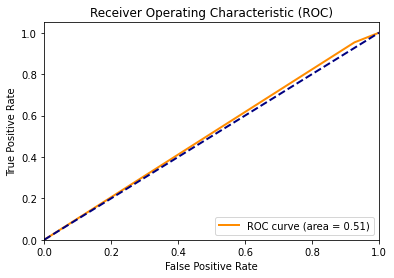

Metrics saved successfully


In [57]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Capsule Network+Dense

In [5]:
import tensorflow as tf
import numpy as np
import cv2
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import pandas as pd

# Start time
start_time = time.time()

# Assume X_train, X_test, y_train, y_test are available

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of MobileNet

X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j


# Load pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Capsule Network
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((-1, 1024))(x)  # Reshape to 3D tensor for Capsule Network
x = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # Use softmax activation for multi-class classification

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,413,570 (13.02 MB)

 Trainable params: 184,706 (721.51 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.5484 - loss: 0.6892 - val_accuracy: 0.6500 - val_loss: 0.6459
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.7375 - loss: 0.5896 - val_accuracy: 0.7357 - val_loss: 0.5344
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.8320 - loss: 0.4149 - val_accuracy: 0.8000 - val_loss: 0.4326
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.8653 - loss: 0.3086 - val_accuracy: 0.7571 - val_loss: 0.4547
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.8871 - loss: 0.2559 - val_accuracy: 0.8214 - val_loss: 0.3879
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.8991 - loss: 0.2394 - val_accuracy: 0.8357 - val_loss: 0.4086
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9252 - loss: 0.1789 - val_accuracy: 0.7357 - val_loss: 0.5946
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.8948 - loss: 0.2311 - val_accuracy: 0.

Validation Loss: 0.3878922462463379
Validation Accuracy: 0.8214285969734192
Test Loss: 0.3779519200325012
Test Accuracy: 0.8333333134651184
Inference Time (Test set): 2.183793067932129 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       150
           1       0.92      0.73      0.81       150

    accuracy                           0.83       300
   macro avg       0.85      0.83      0.83       300
weighted avg       0.85      0.83      0.83       300

Confusion Matrix:
[[141   9]
 [ 41 109]]


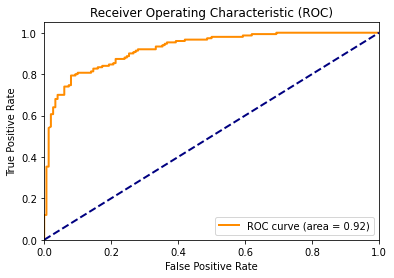

Metrics saved successfully


In [7]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score,matthews_corrcoef,balanced_accuracy_score
import pandas as pd
# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9045 - loss: 0.2226 - val_accuracy: 0.8143 - val_loss: 0.4208
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9380 - loss: 0.1704 - val_accuracy: 0.7357 - val_loss: 0.5770
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.9231 - loss: 0.1725 - val_accuracy: 0.7143 - val_loss: 0.6760
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.9260 - loss: 0.1695 - val_accuracy: 0.8143 - val_loss: 0.4304
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9565 - loss: 0.0960 - val_accuracy: 0.8143 - val_loss: 0.4775
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.9578 - loss: 0.0946 - val_accuracy: 0.7857 - val_loss: 0.5443
Training Time: 20.304555416107178 seconds


Validation Loss: 0.4208030700683594
Validation Accuracy: 0.8142856955528259
Test Loss: 0.37746673822402954
Test Accuracy: 0.8533333539962769
Inference Time (Test set): 2.1478586196899414 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       150
           1       0.86      0.84      0.85       150

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300

Confusion Matrix:
[[130  20]
 [ 24 126]]


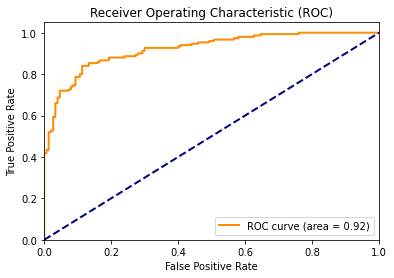

Metrics saved successfully


In [9]:

import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9213 - loss: 0.1930 - val_accuracy: 0.8214 - val_loss: 0.4227
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9397 - loss: 0.1718 - val_accuracy: 0.8214 - val_loss: 0.4174
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9414 - loss: 0.1510 - val_accuracy: 0.8214 - val_loss: 0.4270
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9574 - loss: 0.1110 - val_accuracy: 0.7429 - val_loss: 0.5820
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.8687 - loss: 0.2877 - val_accuracy: 0.8286 - val_loss: 0.3770
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9528 - loss: 0.1326 - val_accuracy: 0.8071 - val_loss: 0.5290
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9583 - loss: 0.0963 - val_accuracy: 0.7429 - val_loss: 0.6624
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9481 - loss: 0.1289 - val_accu

Validation Loss: 0.3770364820957184
Validation Accuracy: 0.8285714387893677
Test Loss: 0.348311185836792
Test Accuracy: 0.8600000143051147
Inference Time (Test set): 2.185112714767456 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       150
           1       0.94      0.77      0.85       150

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300

Confusion Matrix:
[[142   8]
 [ 34 116]]


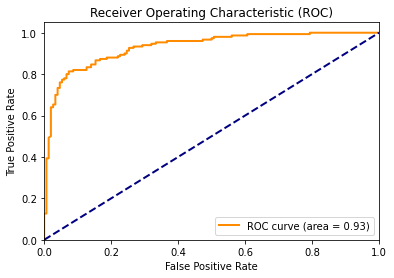

Metrics saved successfully


In [11]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9469 - loss: 0.1595 - val_accuracy: 0.8357 - val_loss: 0.4485
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9571 - loss: 0.0934 - val_accuracy: 0.8286 - val_loss: 0.4420
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9868 - loss: 0.0543 - val_accuracy: 0.8214 - val_loss: 0.5370
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9914 - loss: 0.0315 - val_accuracy: 0.8214 - val_loss: 0.4889
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9908 - loss: 0.0354 - val_accuracy: 0.8357 - val_loss: 0.5316
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9894 - loss: 0.0243 - val_accuracy: 0.8357 - val_loss: 0.5313
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9991 - loss: 0.0141 - val_accuracy: 0.8286 - val_loss: 0.5924
Training Time: 24.345178604125977 seconds


Validation Loss: 0.44202861189842224
Validation Accuracy: 0.8285714387893677
Test Loss: 0.38220804929733276
Test Accuracy: 0.8633333444595337
Inference Time (Test set): 2.175905466079712 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       150
           1       0.89      0.83      0.86       150

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300

Confusion Matrix:
[[134  16]
 [ 25 125]]


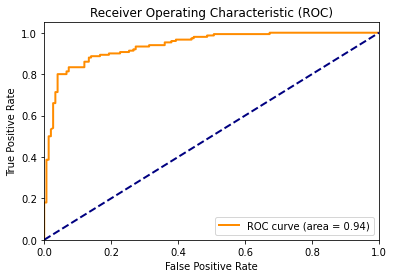

Metrics saved successfully


In [13]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_1000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_1000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")